# Question 1: Supervised Learning for Bioprinting

**Background**: Bioprinting uses additive manufacturing to create three-dimensional structures containing living cells, enabling controlled in vitro experiments that better mimic the tumour microenvironment. Certain printing parameters, such as extrusion pressure and nozzle diameter, can substantially reduce post-printing cell viability. Recent work has shown that supervised machine learning models can predict printing outcomes, including cell viability, from printer and bioink parameters. In *Machine Assisted Experimentation of Extrusion-Based Bioprinting Systems*, Tian et al. compiled a multi-laboratory dataset of 617 cell viability measurements and applied several ML models to predict printing outcomes.

**Objective**: In this question, you will partially reproduce and extend the supervised learning analysis of Tian et al. You will preprocess the experimental dataset and train two classification models to
predict whether a given set of bioprinting parameters results in acceptable cell viability (Yes/No). Assume that cell viability is considered acceptable if it exceeds the threshold defined in the paper.

### (1a) Written Long Answer

##### 1. Define and explain precision and recall in the context of binary classification. Provide and explain the formula for each metric.

- Precision is a metric that measures the accuracy of positive predictions ("Of the positive predictions, how many were correctly positive?")

        Precision = TP / (TP + FP), where TP is the amount of true positives and FP is the amount of false positives
- Recall is a metric that measures the model's ability to correctly classify positives ("How many positive predictions were correctly labelled?")

        Recall = TP / (TP + FN), where TP is the amount of true positives and FN is the amount of false negatives

##### 2. Why can accuracy alone be misleading when evaluating classification models? Explain why precision and recall are important complementary metrics, and give a concrete example.

Accuracy alone can be misleading when one class appears infrequently. For example, for a dataset where class A appears 1% of the time, we can apply a model that predicts class B 100% of the time. This would result in an accuracy of 100%, but of course this model is effectively useless. This is why precision and recall are important metrics to use as they tell you about false positives and false negatives. For example, a model may want to avoid false negatives as much as possible, like in bank fraud prediction, as the consequence of a false negative is extremely dire.

### (1b) Data Preprocessing

In [33]:
import pandas as pd

ds = pd.read_csv("Cell viability and extrusion dataset V1.csv")
ds.head()

,Reference,DOI,Final_Alginate_Conc_(%w/v),Final_Gelatin_Conc_(%w/v),Final_GelMA_Conc_(%w/v),Final_Hyaluronic_Acid_Conc_(%w/v),Final_MeHA_Conc_(%w/v),Final_NorHA_Conc_(%w/v),Final_Fibroin/Fibrinogen_Conc_(%w/v),Final_P127_Conc_(%w/v),...,Saline_Solution_Used?,EtOH_Solution_Used?,Photoinitiator_Used?,Enzymatic_Crosslinker_Used?,Matrigel_Used?,Conical_or_Straight_Nozzle,Primary/Not_Primary,Viability_at_time_of_observation_(%),Acceptable_Viability_(Yes/No),Acceptable_Pressure_(Yes/No)
0,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,2.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,96.0,Y,Y
1,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,2.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,72.0,N,N
2,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,2.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,80.0,Y,Y
3,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,0.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,96.0,Y,Y
4,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,0.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,77.0,N,N


- Handling missing values for bioink temperature as described in the paper

In [34]:
ds["Syringe_Temperature_(°C)"] = ds["Syringe_Temperature_(°C)"].fillna(22)
ds["Substrate_Temperature_(°C)"] = ds["Substrate_Temperature_(°C)"].fillna(22)

- Removing features with more than 50% missing values

In [35]:
ds = ds.dropna(thresh=ds.shape[1] * 0.5)

- Data cleaning

In [36]:
# Drop unnecessary columns
ds = ds.drop("Reference", axis=1)
ds = ds.drop("DOI", axis=1)
ds = ds.drop("Viability_at_time_of_observation_(%)", axis=1)

In [37]:
# Clean numeric columns
ds["Fiber_Diameter_(µm)"] = (
    ds["Fiber_Diameter_(µm)"]
    .astype(str)
    .str.extract(r"([-+]?\d*\.?\d+)")
    .astype(float)
)


- Imputing remaining missing values using KNNImputer from scikit-learn

In [38]:
from sklearn.impute import KNNImputer

numeric_cols = ds.select_dtypes(include="number").columns

imputer = KNNImputer(
    n_neighbors = 30
)

ds[numeric_cols] = imputer.fit_transform(ds[numeric_cols])

- Scaling continuous features using MinMaxScaler

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

continuous_cols = ds.select_dtypes(include="number").columns
ds[continuous_cols] = scaler.fit_transform(ds[continuous_cols])

- Converting categorical features to binary

In [40]:
# Convert columns to binary
ds["Cell_Culture_Medium_Used?"] = (
    ds["Cell_Culture_Medium_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["DI_Water_Used?"] = (
    ds["DI_Water_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["Precrosslinking_Solution_Used?"] = (
    ds["Precrosslinking_Solution_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["Saline_Solution_Used?"] = (
    ds["Saline_Solution_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["EtOH_Solution_Used?"] = (
    ds["EtOH_Solution_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["Photoinitiator_Used?"] = (
    ds["Photoinitiator_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["Enzymatic_Crosslinker_Used?"] = (
    ds["Enzymatic_Crosslinker_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["Matrigel_Used?"] = (
    ds["Matrigel_Used?"]
    .str.strip()
    .str.upper()
    .map({"Y": 1, "N": 0})
)

ds["Conical_or_Straight_Nozzle"] = (
    ds["Conical_or_Straight_Nozzle"]
    .str.strip()
    .str.upper()
    .map({"C": 1, "S": 0})
)

ds["Primary/Not_Primary"] = (
    ds["Primary/Not_Primary"]
    .str.strip()
    .str.upper()
    .map({"PRIMARY": 1, "NOT_PRIMARY": 0})
)

- Removing “Acceptable Pressure” from the feature set

In [41]:
ds = ds.drop("Acceptable_Pressure_(Yes/No)", axis=1)

- Drop rows with null Conical_or_Straight_Nozzle values

In [53]:
ds = ds.dropna(subset=["Conical_or_Straight_Nozzle"])

### (1c) Decision Tree Classifier

In [54]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = ds.drop("Acceptable_Viability_(Yes/No)", axis=1)
y = ds["Acceptable_Viability_(Yes/No)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

dt = tree.DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20
)
dt = dt.fit(X_train, y_train)

[Text(0.625, 0.9, 'x[13] <= 0.089\ngini = 0.474\nsamples = 411\nvalue = [159, 252]'),
 Text(0.39285714285714285, 0.7, 'x[27] <= 0.051\ngini = 0.446\nsamples = 366\nvalue = [123.0, 243.0]'),
 Text(0.5089285714285714, 0.8, 'True  '),
 Text(0.14285714285714285, 0.5, 'x[29] <= 0.086\ngini = 0.327\nsamples = 199\nvalue = [41, 158]'),
 Text(0.07142857142857142, 0.3, 'gini = 0.482\nsamples = 37\nvalue = [15, 22]'),
 Text(0.21428571428571427, 0.3, 'x[27] <= 0.028\ngini = 0.269\nsamples = 162\nvalue = [26, 136]'),
 Text(0.14285714285714285, 0.1, 'gini = 0.128\nsamples = 73\nvalue = [5, 68]'),
 Text(0.2857142857142857, 0.1, 'gini = 0.361\nsamples = 89\nvalue = [21, 68]'),
 Text(0.6428571428571429, 0.5, 'x[30] <= 0.178\ngini = 0.5\nsamples = 167\nvalue = [82, 85]'),
 Text(0.5, 0.3, 'x[24] <= 0.334\ngini = 0.378\nsamples = 71\nvalue = [18, 53]'),
 Text(0.42857142857142855, 0.1, 'gini = 0.19\nsamples = 47\nvalue = [5, 42]'),
 Text(0.5714285714285714, 0.1, 'gini = 0.497\nsamples = 24\nvalue = [13, 1

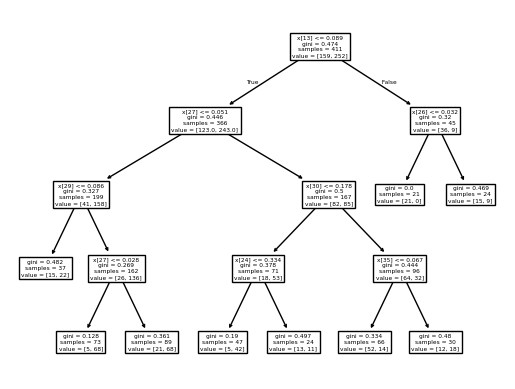

In [55]:
tree.plot_tree(dt)

### (1d) Support Vector Machine

In [58]:
from sklearn import svm

X = ds.drop("Acceptable_Viability_(Yes/No)", axis=1)
y = ds["Acceptable_Viability_(Yes/No)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False
